## 基于深度学习的窗口划分问题

###### 2018.4.1 by Zebang Li

针对时序数据的窗口划分问题是一个基础而易于忽略的课题，一个合适的窗口划分是下一步相关研究的重要前提。本文针对时序数据的窗口划分问题，提出一个基于深度学习的模型框架，为时序数据的窗口划分问题提供了一种方案。

这里展示了所有基础代码，将一般的深度神经网络监督学习用于窗口分割。
需要支持的基础包有

>* time                  基础时间

>* numpy                 基础数组操作

>* h5py                  一种数据格式包(可不用)

>* matplotlib.pyplot         基础作图

>* scipy                 基础机器学习包

>* PIL                  图像处理标准库(Python Imaging Library)

>* dnn_app_utils_v2          包含深度学习技术细节(已放于本文件同目录下)

以上各个模块的安装在网上都能找到便捷方式，其中若研究者欲修改模型细节及其结构，只需专注于dnn_app_utils_v2文件的修改，详见同一目录下dnn_app_utils_v2.py

### 模型与数据准备

以下是模型准备，首先导入以上包，注释部分是读取数据和控制图形大小，首次使用可先把这些部分注释掉

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *

# train_x = np.load("train_x.npy")
# train_y = np.load("train_y.npy")
# test_x = np.load("test_x.npy")
# test_y = np.load("test_y.npy")

plt.rcParams['figure.figsize'] = (7.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

L:\Program Files\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 各类数据生成

生成趋势数据，且逐步加入噪声

In [2]:
# 生成趋势数据

m1 = np.arange(10,0,-1)
m2 = np.arange(10)
m = np.concatenate((m2,m1))

train_x_orig = np.array([])
for i in range(0,10):
    train_x_orig = np.concatenate((train_x_orig,[x+i for x in m]))

print(train_x_orig)
print ("train_x_orig's shape: " + str(train_x_orig.shape))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  9.  8.  7.  6.  5.  4.  3.
  2.  1.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 10.  9.  8.  7.  6.
  5.  4.  3.  2.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 11. 10.  9.
  8.  7.  6.  5.  4.  3.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 12.
 11. 10.  9.  8.  7.  6.  5.  4.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.
 14. 13. 12. 11. 10.  9.  8.  7.  6.  5.  5.  6.  7.  8.  9. 10. 11. 12.
 13. 14. 15. 14. 13. 12. 11. 10.  9.  8.  7.  6.  6.  7.  8.  9. 10. 11.
 12. 13. 14. 15. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.  7.  8.  9. 10.
 11. 12. 13. 14. 15. 16. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  8.  9.
 10. 11. 12. 13. 14. 15. 16. 17. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.
  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 18. 17. 16. 15. 14. 13. 12.
 11. 10.]
train_x_orig's shape: (200,)


In [3]:
# 设定滑动学习序列的步长step和邻域长度lenth
# 并整理成模型允许的数据结构

step = 1
lenth = 5
w = np.array([list(train_x_orig[0:0+lenth])])
for i in range(step, len(train_x_orig)-10, step):
    w2 = np.array([list(train_x_orig[i:i+lenth])])
    w = np.concatenate((w,w2),axis=0)
print(w)
print ("w's shape: " + str(w.shape))

[[ 0.  1.  2.  3.  4.]
 [ 1.  2.  3.  4.  5.]
 [ 2.  3.  4.  5.  6.]
 [ 3.  4.  5.  6.  7.]
 [ 4.  5.  6.  7.  8.]
 [ 5.  6.  7.  8.  9.]
 [ 6.  7.  8.  9. 10.]
 [ 7.  8.  9. 10.  9.]
 [ 8.  9. 10.  9.  8.]
 [ 9. 10.  9.  8.  7.]
 [10.  9.  8.  7.  6.]
 [ 9.  8.  7.  6.  5.]
 [ 8.  7.  6.  5.  4.]
 [ 7.  6.  5.  4.  3.]
 [ 6.  5.  4.  3.  2.]
 [ 5.  4.  3.  2.  1.]
 [ 4.  3.  2.  1.  1.]
 [ 3.  2.  1.  1.  2.]
 [ 2.  1.  1.  2.  3.]
 [ 1.  1.  2.  3.  4.]
 [ 1.  2.  3.  4.  5.]
 [ 2.  3.  4.  5.  6.]
 [ 3.  4.  5.  6.  7.]
 [ 4.  5.  6.  7.  8.]
 [ 5.  6.  7.  8.  9.]
 [ 6.  7.  8.  9. 10.]
 [ 7.  8.  9. 10. 11.]
 [ 8.  9. 10. 11. 10.]
 [ 9. 10. 11. 10.  9.]
 [10. 11. 10.  9.  8.]
 [11. 10.  9.  8.  7.]
 [10.  9.  8.  7.  6.]
 [ 9.  8.  7.  6.  5.]
 [ 8.  7.  6.  5.  4.]
 [ 7.  6.  5.  4.  3.]
 [ 6.  5.  4.  3.  2.]
 [ 5.  4.  3.  2.  2.]
 [ 4.  3.  2.  2.  3.]
 [ 3.  2.  2.  3.  4.]
 [ 2.  2.  3.  4.  5.]
 [ 2.  3.  4.  5.  6.]
 [ 3.  4.  5.  6.  7.]
 [ 4.  5.  6.  7.  8.]
 [ 5.  6.  

根据研究目标对数据进行标定，即标定哪些邻域的中心点是分割点，这里的标定按照研究需要，这里我们仅把关键转折点进行标定

In [4]:
train_y_orig = []
for x in w:
    flag = 0
    if (x[2] >= x[1] and x[2] >= x[3]):
        flag = 1
    if (x[2] <= x[1] and x[2] <= x[3]):
        flag = 1
    train_y_orig = np.append(train_y_orig, flag)
    
for i in range(0, len(train_y_orig)):
    if (train_y_orig[i] == 1) and (train_y_orig[i+1] == 1):
        train_y_orig[i+1] = 0
        
print(train_y_orig)
print ("train_y_orig's shape: " + str(train_y_orig.shape))

c = train_y_orig.copy()
print ("c's shape: " + str(c.shape))

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
train_y_orig's shape: (190,)
c's shape: (190,)


以下对原始数据加入噪声

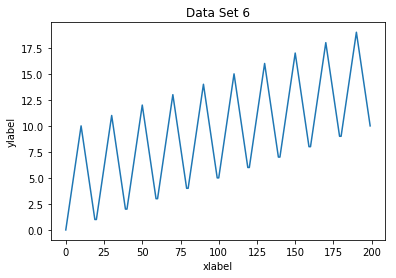

In [5]:
noisy = 0*np.random.rand(len(train_x_orig))
train_x_orig = train_x_orig + noisy

plt.plot(train_x_orig[0:200])
plt.title('Data Set 6')
plt.ylabel('ylabel')
plt.xlabel('xlabel')
plt.show()

对加入噪声后的数据再次产生“滑动学习序列”，生成模型容许的数据结构

In [6]:
step = 1
lenth = 5
w = np.array([list(train_x_orig[0:0+lenth])])
for i in range(step, len(train_x_orig)-10, step):
    w2 = np.array([list(train_x_orig[i:i+lenth])])
    w = np.concatenate((w,w2),axis=0)
print(w)
print ("w's shape: " + str(w.shape))

[[ 0.  1.  2.  3.  4.]
 [ 1.  2.  3.  4.  5.]
 [ 2.  3.  4.  5.  6.]
 [ 3.  4.  5.  6.  7.]
 [ 4.  5.  6.  7.  8.]
 [ 5.  6.  7.  8.  9.]
 [ 6.  7.  8.  9. 10.]
 [ 7.  8.  9. 10.  9.]
 [ 8.  9. 10.  9.  8.]
 [ 9. 10.  9.  8.  7.]
 [10.  9.  8.  7.  6.]
 [ 9.  8.  7.  6.  5.]
 [ 8.  7.  6.  5.  4.]
 [ 7.  6.  5.  4.  3.]
 [ 6.  5.  4.  3.  2.]
 [ 5.  4.  3.  2.  1.]
 [ 4.  3.  2.  1.  1.]
 [ 3.  2.  1.  1.  2.]
 [ 2.  1.  1.  2.  3.]
 [ 1.  1.  2.  3.  4.]
 [ 1.  2.  3.  4.  5.]
 [ 2.  3.  4.  5.  6.]
 [ 3.  4.  5.  6.  7.]
 [ 4.  5.  6.  7.  8.]
 [ 5.  6.  7.  8.  9.]
 [ 6.  7.  8.  9. 10.]
 [ 7.  8.  9. 10. 11.]
 [ 8.  9. 10. 11. 10.]
 [ 9. 10. 11. 10.  9.]
 [10. 11. 10.  9.  8.]
 [11. 10.  9.  8.  7.]
 [10.  9.  8.  7.  6.]
 [ 9.  8.  7.  6.  5.]
 [ 8.  7.  6.  5.  4.]
 [ 7.  6.  5.  4.  3.]
 [ 6.  5.  4.  3.  2.]
 [ 5.  4.  3.  2.  2.]
 [ 4.  3.  2.  2.  3.]
 [ 3.  2.  2.  3.  4.]
 [ 2.  2.  3.  4.  5.]
 [ 2.  3.  4.  5.  6.]
 [ 3.  4.  5.  6.  7.]
 [ 4.  5.  6.  7.  8.]
 [ 5.  6.  

取以上生成的数据的前3/4作为训练数据，后1/4作为测试数据，并且对每个样本做标准化处理

In [7]:
train_x = w[0:len(w)*3//4]
test_x = w[len(w)*3//4:len(w)]

train_x = train_x.T
test_x = test_x.T

# 标准化处理，使得数据取值在0-1之间.
train_x = (train_x-train_x.min())/(train_x.max()-train_x.min())
test_x = (test_x-test_x.min())/(test_x.max()-test_x.min())

train_y = np.array([c[0:len(c)*3//4]])
test_y = np.array([c[len(c)*3//4:len(c)]])

print ("train_x's shape: " + str(train_x.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("test_y's shape: " + str(test_y.shape))

train_x's shape: (5, 142)
train_y's shape: (1, 142)
test_x's shape: (5, 48)
test_y's shape: (1, 48)


### 模型结构

采取5层神经网络，每层神经元个数依次为[5, 10, 7, 5, 1]，激活函数为RELU，最后一层为Sigmoid

在下一节中，研究者可自行设置模型参数如下

>* layers_dims    模型神经元结构，例如[5, 10, 7, 5, 1]表示5层网络，亦可为其它多层网络，例如[5, 10, 7, 1]即变为4层网络
>* learning_rate   学习率，即梯度下降法中每次迭代的该变量系数
>* num_iterations   最大迭代次数
>* print_cost   选择是否打印每次迭代cost函数值

这里只是事先定义模型结构函数，详见以下代码

In [8]:
# GRADED FUNCTION: L_layer_model
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, print_cost):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
        if cost <= 0.15:
            learning_rate = 0.005
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters =  update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

### 模型实施

以下是模型实施，首先训练得到参数集parameters，然后再将此参数集传入用以测试预测

训练模型时研究者可主要调整以下参数

>* layers_dims    模型神经元结构，例如[5, 10, 7, 5, 1]表示5层网络，亦可为其它多层网络，例如[5, 10, 7, 1]即变为4层网络
>* learning_rate   学习率，即梯度下降法中每次迭代的该变量系数
>* num_iterations   最大迭代次数
>* print_cost   选择是否打印每次迭代cost函数值

这里必须指出修参是一件麻烦而关键的操作

Cost after iteration 0: 0.689161
Cost after iteration 100: 0.580872
Cost after iteration 200: 0.501249
Cost after iteration 300: 0.440460
Cost after iteration 400: 0.394190
Cost after iteration 500: 0.361708
Cost after iteration 600: 0.342091
Cost after iteration 700: 0.331676
Cost after iteration 800: 0.326698
Cost after iteration 900: 0.324480
Cost after iteration 1000: 0.323497
Cost after iteration 1100: 0.323040
Cost after iteration 1200: 0.322799
Cost after iteration 1300: 0.322637
Cost after iteration 1400: 0.322507
Cost after iteration 1500: 0.322401
Cost after iteration 1600: 0.322310
Cost after iteration 1700: 0.322222
Cost after iteration 1800: 0.322136
Cost after iteration 1900: 0.322052
Cost after iteration 2000: 0.321959
Cost after iteration 2100: 0.321873
Cost after iteration 2200: 0.321787
Cost after iteration 2300: 0.321702
Cost after iteration 2400: 0.321619
Cost after iteration 2500: 0.321538
Cost after iteration 2600: 0.321457
Cost after iteration 2700: 0.321376
Cost

Cost after iteration 23000: 0.057277
Cost after iteration 23100: 0.055595
Cost after iteration 23200: 0.054318
Cost after iteration 23300: 0.053334
Cost after iteration 23400: 0.051998
Cost after iteration 23500: 0.050858
Cost after iteration 23600: 0.049907
Cost after iteration 23700: 0.048675
Cost after iteration 23800: 0.047597
Cost after iteration 23900: 0.046579
Cost after iteration 24000: 0.045645
Cost after iteration 24100: 0.044581
Cost after iteration 24200: 0.043616
Cost after iteration 24300: 0.042735
Cost after iteration 24400: 0.041920
Cost after iteration 24500: 0.040903
Cost after iteration 24600: 0.040089
Cost after iteration 24700: 0.039192
Cost after iteration 24800: 0.038379
Cost after iteration 24900: 0.037678
Cost after iteration 25000: 0.036870
Cost after iteration 25100: 0.036003
Cost after iteration 25200: 0.035541
Cost after iteration 25300: 0.034505
Cost after iteration 25400: 0.033906
Cost after iteration 25500: 0.033268
Cost after iteration 25600: 0.032565
C

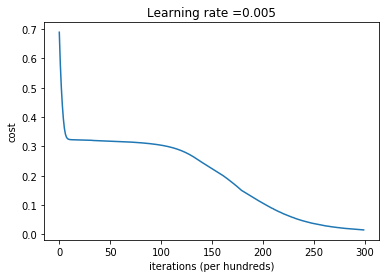

In [9]:
layers_dims = [5, 10, 7, 5, 1] #  5-layer model
learning_rate = 0.0075
num_iterations = 30000
print_cost=True

parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate, num_iterations, print_cost)

In [10]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.9999999999999999


把模型结果绘制成图形，这里由于训练数据庞大，我们往往仅选取一部分数据作图

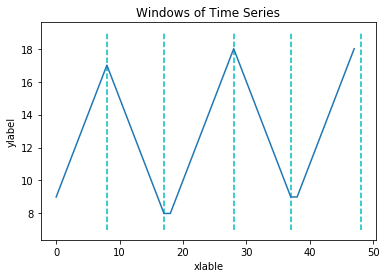

In [11]:
plot_data = train_x_orig[len(w)*3//4:len(w)]
x = list(range(0,len(w)-len(w)*3//4))
plt.plot(x,plot_data)
p = predictions_test[:,]

s = 0
for i in p[0]:
    if i == 1.0:
        x = s*step + 2 # 注意这里的平移量要设置准确
        plt.vlines(x, plot_data.min()-1, plot_data.max()+1, colors = "c", linestyles = "dashed")
    s += 1
    
plt.ylabel('ylabel')
plt.xlabel('xlable')
plt.title("Windows of Time Series")
plt.show()

### 实际数据实验

这里导入tushare包，这个包能够方便获取国内各股票数据，详见[官方教程][1]

这里展示选取代码000006的股票2013-01-23到2017-12-26开盘价，其余例子亦可测试

代码结构同上，先获取数据，再生成“学习序列”，然后人工标定，最后训练。为了执行的便捷性，以下代码就不再如上述分块讲解，而是一步到位训练得到参数

[1]: http://tushare.org/

Cost after iteration 0: 0.698098
Cost after iteration 100: 0.273737
Cost after iteration 200: 0.265189
Cost after iteration 300: 0.253879
Cost after iteration 400: 0.237866
Cost after iteration 500: 0.220858
Cost after iteration 600: 0.198673
Cost after iteration 700: 0.175414
Cost after iteration 800: 0.170745
Cost after iteration 900: 0.145146
Cost after iteration 1000: 0.143380
Cost after iteration 1100: 0.142035
Cost after iteration 1200: 0.140897
Cost after iteration 1300: 0.139887
Cost after iteration 1400: 0.138858
Cost after iteration 1500: 0.137841
Cost after iteration 1600: 0.136831
Cost after iteration 1700: 0.135871
Cost after iteration 1800: 0.134888
Cost after iteration 1900: 0.133906
Cost after iteration 2000: 0.132978
Cost after iteration 2100: 0.132088
Cost after iteration 2200: 0.131173
Cost after iteration 2300: 0.130386
Cost after iteration 2400: 0.129448
Cost after iteration 2500: 0.128543
Cost after iteration 2600: 0.127668
Cost after iteration 2700: 0.126827
Cost

Cost after iteration 22900: 0.019696
Cost after iteration 23000: 0.019679
Cost after iteration 23100: 0.019445
Cost after iteration 23200: 0.019363
Cost after iteration 23300: 0.019231
Cost after iteration 23400: 0.019155
Cost after iteration 23500: 0.019047
Cost after iteration 23600: 0.018848
Cost after iteration 23700: 0.018758
Cost after iteration 23800: 0.018596
Cost after iteration 23900: 0.018489
Cost after iteration 24000: 0.018384
Cost after iteration 24100: 0.018257
Cost after iteration 24200: 0.018159
Cost after iteration 24300: 0.018030
Cost after iteration 24400: 0.017925
Cost after iteration 24500: 0.017855
Cost after iteration 24600: 0.017704
Cost after iteration 24700: 0.017661
Cost after iteration 24800: 0.017507
Cost after iteration 24900: 0.017389
Cost after iteration 25000: 0.017289
Cost after iteration 25100: 0.017188
Cost after iteration 25200: 0.017102
Cost after iteration 25300: 0.017039
Cost after iteration 25400: 0.016950
Cost after iteration 25500: 0.016793
C

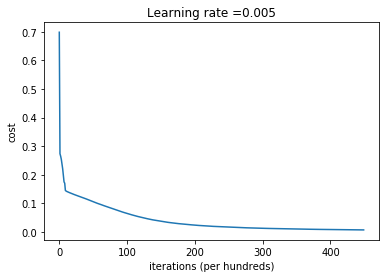

Accuracy: 0.0


ValueError: x and y must have same first dimension, but have shapes (103,) and (0,)

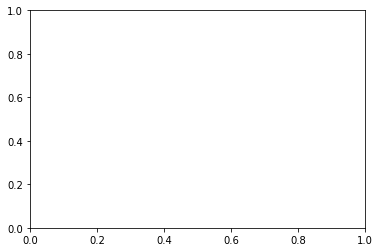

In [12]:
# 导入必要的包
import tushare as ts  
import numpy as np
import matplotlib.pyplot as plt
e = ts.get_hist_data('000010',start='2013-01-23',end='2017-12-26') 
data_x_orig = e['open']

# 生成“学习序列”
step = 1
lenth = 25
w = np.array([list(data_x_orig[0:0+lenth])])
for i in range(step, len(data_x_orig)-lenth, step):
    w2 = np.array([list(data_x_orig[i:i+lenth])])
    w = np.concatenate((w,w2),axis=0)

# 人工标定，这里粗略标定一些局部极值点为分割点
train_y_orig = []
for x in w:
    flag = 0
    if (x[10]>x[9])*(x[10]>x[8])*(x[10]>x[7])*(x[10]>x[6])*(x[10]>x[5])*(x[10]>x[4])*(x[10]>x[3]) and (x[10]>x[11])*(x[10]>x[12])*(x[10]>x[13])*(x[10]>x[14])*(x[10]>x[15])*(x[10]>x[16])*(x[10]>x[17]):
        flag = 1
    if (x[10]<x[9])*(x[10]<x[8])*(x[10]<x[7])*(x[10]<x[6])*(x[10]<x[5])*(x[10]<x[4])*(x[10]<x[3]) and (x[10]<x[11])*(x[10]<x[12])*(x[10]<x[13])*(x[10]<x[14])*(x[10]<x[15])*(x[10]<x[16])*(x[10]<x[17]):
        flag = 1
    train_y_orig.append(flag)
c = train_y_orig.copy()

# 再标准化后得到模型允许的训练数据
test_x = w.T
test_y = np.array([c[0:len(c)]])
test = []
for a in test_x.T:
    min_a = a.min()
    max_a = a.max()
    a = (a-min_a)/(max_a-min_a)
    test.append(a)
test = np.array(test).T

# 设置模型参数
layers_dims = [25, 10, 7, 5, 1]
learning_rate = 0.095
num_iterations = 45000
print_cost = True

# 训练及其测试
parameters = L_layer_model(test.T[0:500].T, test_y.T[0:500].T, layers_dims, learning_rate, num_iterations, print_cost)
predictions = predict(test.T[450:580].T, test_y.T[450:580].T, parameters)

ValueError: x and y must have same first dimension, but have shapes (103,) and (0,)

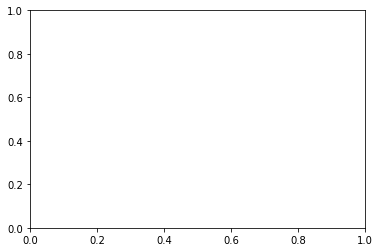

In [13]:
# 将结果绘制成图像
plot_data = data_x_orig[450:553]
x = list(range(0,-450+553))
plt.plot(x,plot_data)
p = predictions[:,]
s = 0
for i in p[0]:
    if i == 1.0:
        x = s*step+10
        print(x)
        plt.vlines(x, plot_data.min()-1, plot_data.max()+1, colors = "c", linestyles = "dashed")
    s += 1    
plt.ylabel('ylabel')
plt.xlabel('xlable')
plt.title("Windows of Time Series")
plt.show()

### 其它

* 为了跨平台调用(例如想要在matlab等其它平台实验)需要共享数据，或是为了在反复实验中不每次都下载读取数据，可以把数据存储在本地，numpy数据存储办法可参见[文档][2]  

> np.save("file.npy",data)

> np.load("file.npy",data)

* 初次调试首先需注意数据格式，请通过shape命令等方式搞清楚数据结构及其内容，代码相应部分也有注释说明

* 修改参数与模型结构是优化结构的关键，这方面需要研究者自行反复调试

* 争取基于TensorFlow编写具有CNN结构的网络用以窗口划分问题，那样会把图像识别的某些核心思想用以时序

[2]: https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.save.html